In [1]:
import os
import time
import sys
import scipy
import glob
import importlib
import _pickle as pkl
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

from datetime import datetime

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [13]:
import trajectory as traj

In [14]:
util.set_sns_style(style='dark', min_fontsize=12)
%matplotlib notebook

In [6]:
importlib.reload(util)

<module 'utils' from '/Users/julianarhee/Repositories/plume-tracking/utils.py'>

In [7]:
# rootdir='/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
rootdir = util.get_rootdir()
print(rootdir)

/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data


In [8]:
src0 = os.path.join(rootdir, 'All_constant_all_increasing_gradient')
dst0 = os.path.join(rootdir, 'jyr', 'vertical_strip', 'selected')
if not os.path.exists(dst0):
    os.makedirs(dst0)

In [11]:
copy_files=False
if copy_files:
    import shutil
    subdirs = ['all_constant_odor_trials', 'all_increasing_gradient_trials']
    for subdir in subdirs:
        src_files = glob.glob(os.path.join(src0, subdir, '*.log'))
        dst_subdir = 'constant' if subdir=='all_constant_odor_trials' else 'gradient'
        if not os.path.exists(os.path.join(dst0, dst_subdir)):
            os.makedirs(os.path.join(dst0, dst_subdir))
        for sfile in src_files:
            fn = os.path.split(sfile)[-1]
            dfile = os.path.join(dst0, dst_subdir, fn)
            shutil.copy(sfile, dfile)

In [12]:
srcdir = dst0
all_logfiles = glob.glob(os.path.join(srcdir, '*', '*.log'))
len(all_logfiles)

93

In [278]:
figid = srcdir.split('/My Drive')[-1]
print(figid)

/Edge_Tracking/Data/jyr/vertical_strip/selected


In [121]:
create_new=False
combined_datafile = os.path.join(srcdir, 'combined.pkl')
if not create_new:
    try:
        with open(combined_datafile, 'rb') as f:
            df0_all = pkl.load(f)
        print(df0_all.shape)
    except Exception as e:
        print(e)
        create_new=True

(3092500, 42)


In [119]:
if create_new:
    d_list = []
    params = {}
    for fp in all_logfiles:
        parent, fn = os.path.split(fp)
        fname = os.path.splitext(fn)[0]

        curr_figdir = os.path.join(parent, 'trajectories')
        if not os.path.exists(curr_figdir):
            os.makedirs(curr_figdir)

        currcond = os.path.split(parent)[-1]
        df0_full, oparams = traj.load_df(fp)
        odor_ix = oparams['odor_ix']
        odor_bounds = oparams['odor_bounds']

        df0_full['condition'] = currcond
        params[fname] = oparams

        fig, ax = pl.subplots()
        ax = butil.plot_trajectory(df0_full, ax=ax, odor_bounds=odor_bounds, 
                             zero_odor_start=True)
        ax.set_title(fn, fontsize=8, loc='left')
        ax.set_aspect(1)

        util.label_figure(fig, '{}'.format(parent.split('/My Drive')[-1]))
        pl.savefig(os.path.join(curr_figdir, '{}.png'.format(fname)), dpi=300)
        pl.close()

        d_list.append(df0_full)
    # combine
    df0_all = pd.concat(d_list, axis=0).reset_index()
    # save
    with open(combined_datafile, 'wb') as f:
        pkl.dump(df0_all, f)


# find ETs

In [441]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [456]:
len(df0_all['filename'].unique())


93

In [452]:
max_instrip_upwind_dist = 500 #250 #250
min_sum_instrip_upwind_dist = 250
min_global_upwind_dist = 500

max_crossovers = 2
ets=[]
for fn, df_ in df0_all.groupby('filename'):
    if butil.is_edgetracking(df_, split_at_crossovers=False,
                             min_outside_bouts=4, 
                             max_crossovers=max_crossovers,
                             min_global_upwind_dist=min_global_upwind_dist, 
                             max_instrip_upwind_dist=max_instrip_upwind_dist,
                             min_sum_instrip_upwind_dist=min_sum_instrip_upwind_dist):
        ets.append(fn)
        
aggr_figname = 'traj_max-crossovers-{}_min-global-upwind-dist-{}_max-instrip-upwind-dist-{}_min-sum-instrip-upwind-dist-{}_n{}'\
                .format(max_crossovers, min_global_upwind_dist, max_instrip_upwind_dist, min_sum_instrip_upwind_dist, len(ets))
print(aggr_figname)

traj_max-crossovers-2_min-global-upwind-dist-500_max-instrip-upwind-dist-500_min-sum-instrip-upwind-dist-250_n36


In [444]:
df0 = df0_all[df0_all['filename'].isin(ets)].copy()

In [445]:
df0[['condition', 'filename']].drop_duplicates().groupby('condition')['filename'].count()

condition
constant    18
gradient    18
Name: filename, dtype: int64

In [446]:
curr_figdir = os.path.join(srcdir, 'ets', 'trajectories')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
existing_ = glob.glob(os.path.join(curr_figdir, '*.png'))
if len(existing_) > 0:
    print("Removing {} existing".format(len(existing_)))
    for f in existing_:
        os.remove(f)
        
for fp, df_ in df0.groupby('fpath'):
    parentdir, fname = os.path.split(fp)
    fn = os.path.splitext(fname)[0]
    all_fp = os.path.join(parentdir, 'trajectories', '{}.png'.format(fn))
    dst_fp = os.path.join(curr_figdir, '{}.png'.format(fn))
    shutil.copy(all_fp, dst_fp)

Removing 39 existing


In [447]:
curr_figdir

'/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data/jyr/vertical_strip/selected/ets/trajectories'

In [448]:
len(df0['fly_id'].unique())

27

In [449]:
len(df0['filename'].unique())

36

# plot

<IPython.core.display.Javascript object>


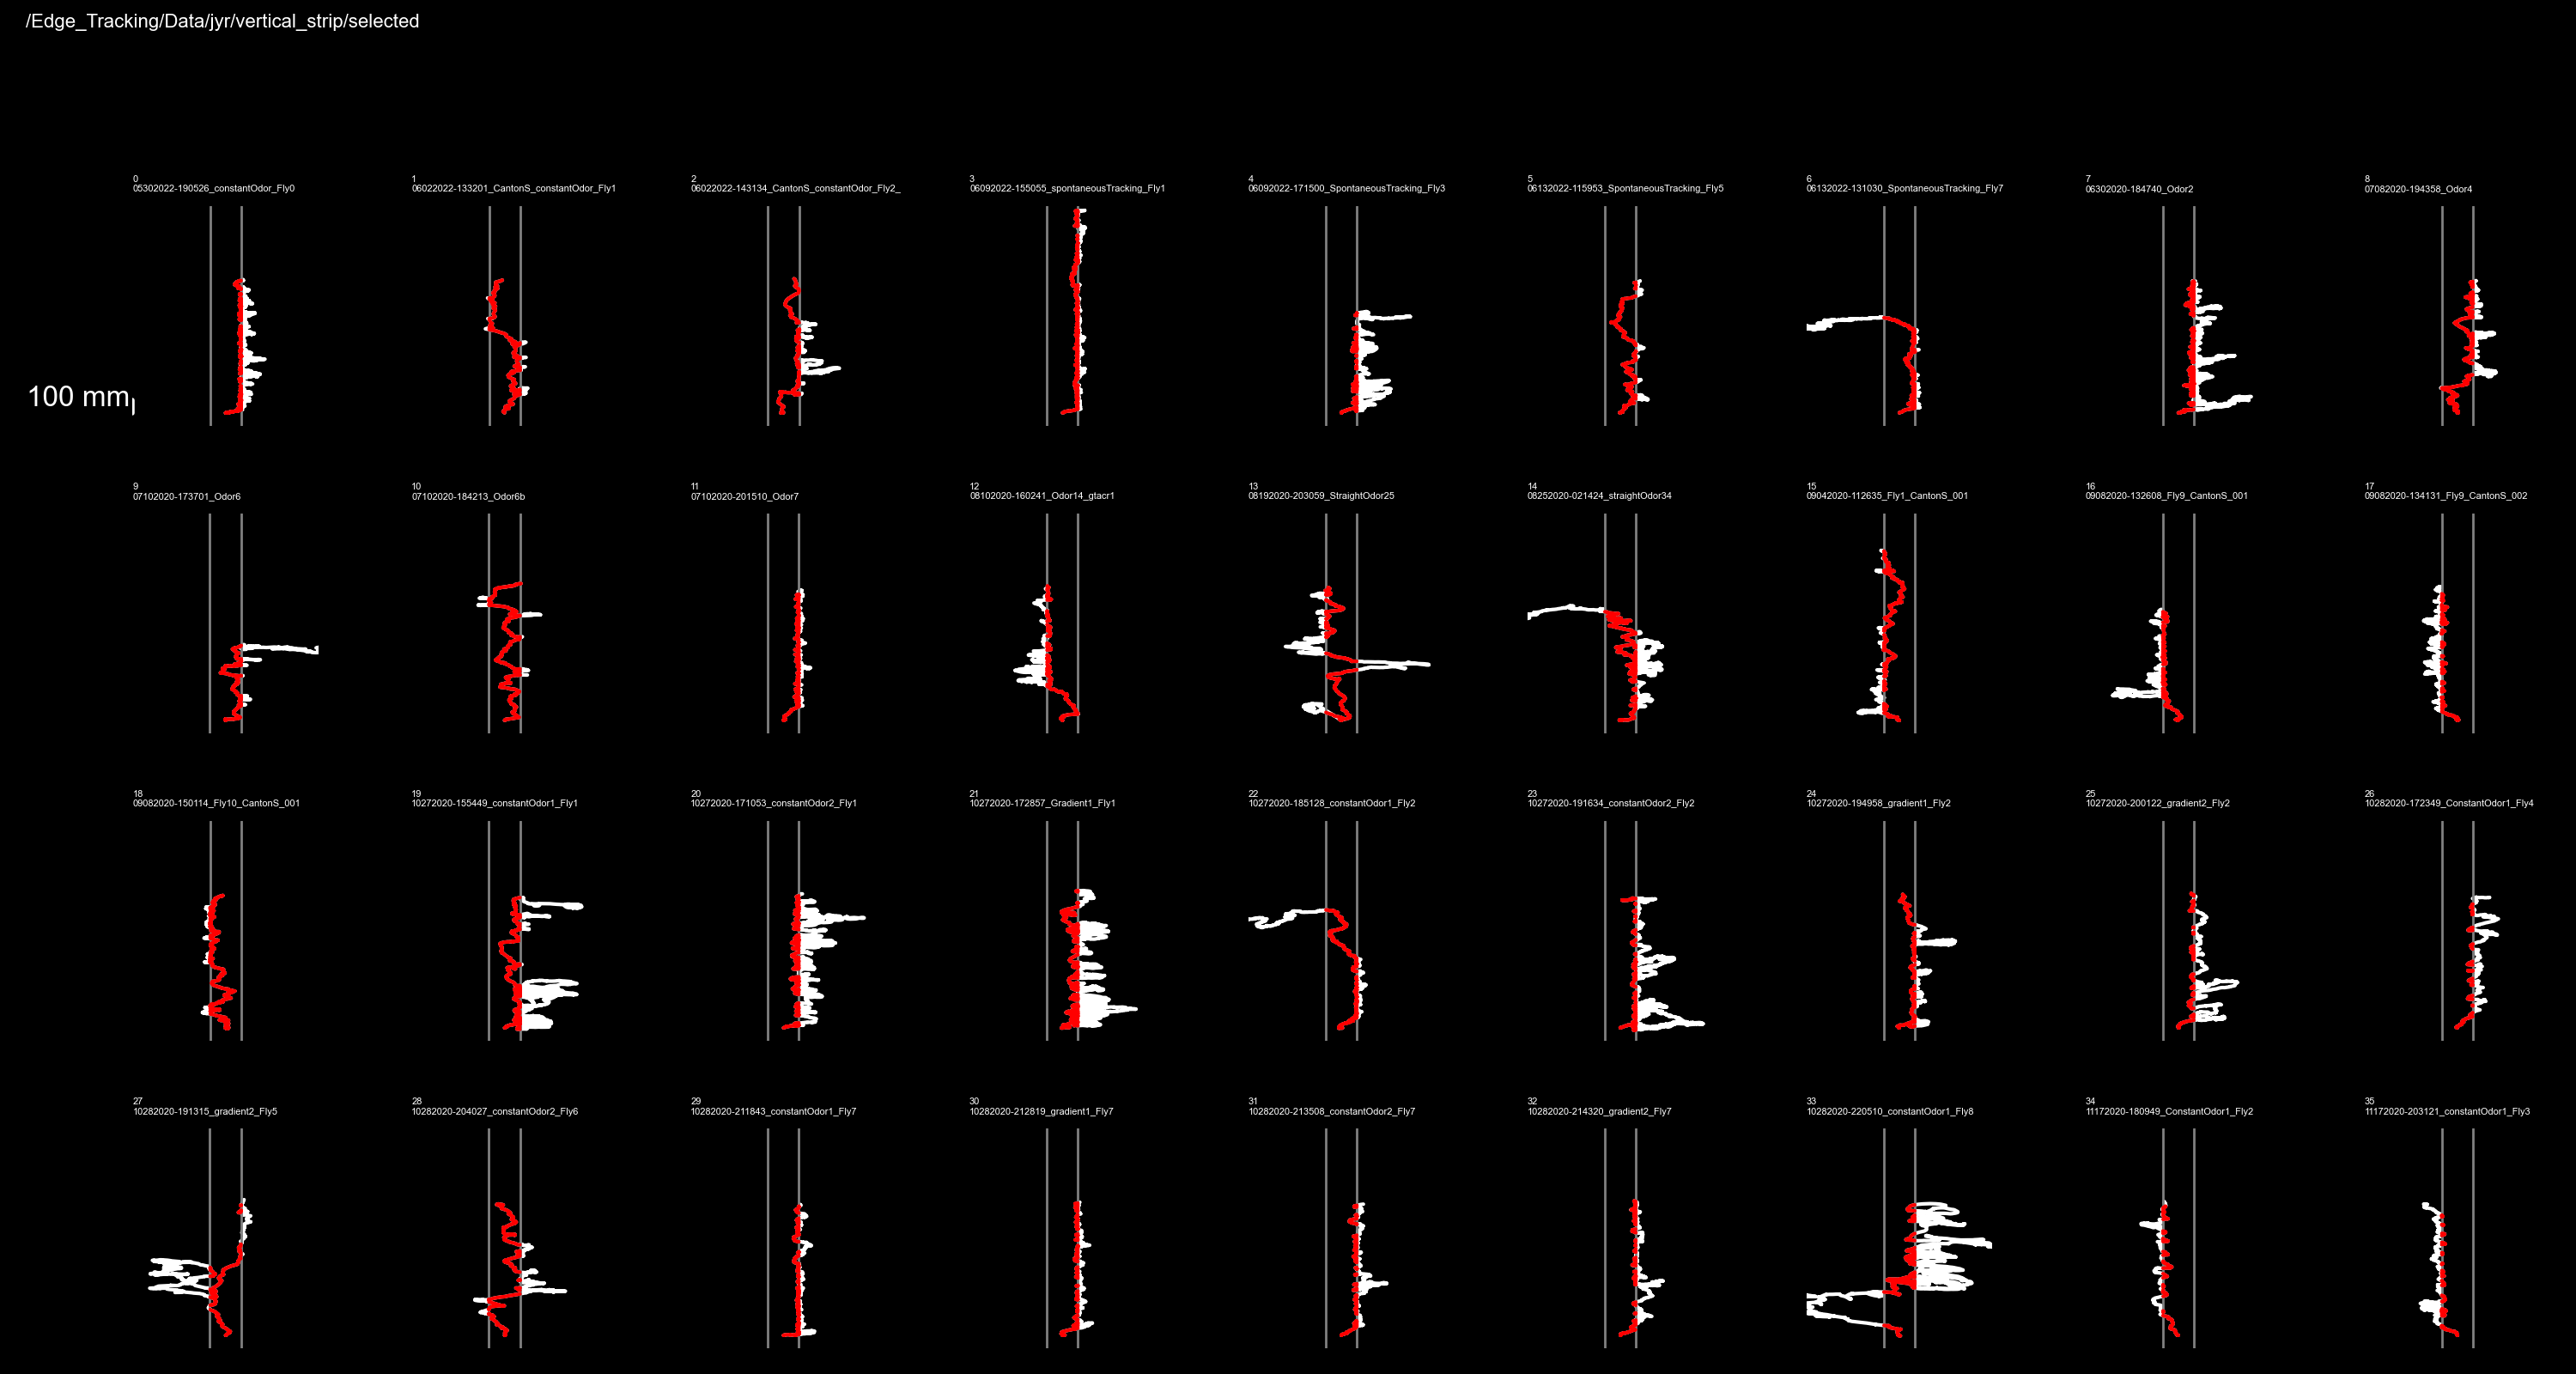

/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data/jyr/vertical_strip/selected/ets/traj_max-crossovers-2_min-global-upwind-dist-500_max-instrip-upwind-dist-500_min-sum-instrip-upwind-dist-250_n36.png


In [454]:
curr_figdir = os.path.join(srcdir, 'ets')
nr=4
nc=9
fig, axn = pl.subplots(nr, nc, figsize=(15,8), sharex=True)
for fi, (fn, df_) in enumerate(df0.groupby('filename')):
    if fi >= nr*nc:
        break
    ax=axn.flat[fi]
    # PLOT
    butil.plot_zeroed_trajectory(df_, ax=ax, traj_lw=1.5, odor_lw=1.0,
                                 strip_width=50, #params[fn]['strip_width'],
                                 strip_sep=1000) #params[fn]['strip_sep'])
    # legend
    ax.axis('off')
    if fi==0:
        leg_xpos=-150; leg_ypos=0; leg_scale=100
        butil.vertical_scalebar(ax, leg_xpos=leg_xpos, leg_ypos=leg_ypos)
    #ax.set_box_aspect(3)
    ax.set_xlim([-150, 150])
    ax.set_ylim([-100, 1600])
    ax.set_title('{}\n{}'.format(fi, fn), fontsize=4, loc='left')

for ax in axn.flat[fi:]:
    ax.axis('off')
    
pl.tight_layout()
pl.subplots_adjust(top=0.85, hspace=0.4, wspace=0.5) #left=0.1, right=0.9, wspace=1, hspace=1, bottom=0.1, top=0.8)

util.label_figure(fig, figid)

pl.savefig(os.path.join(curr_figdir, '{}.png'.format(aggr_figname)))
print(os.path.join(curr_figdir, '{}.png'.format(aggr_figname)))

<IPython.core.display.Javascript object>


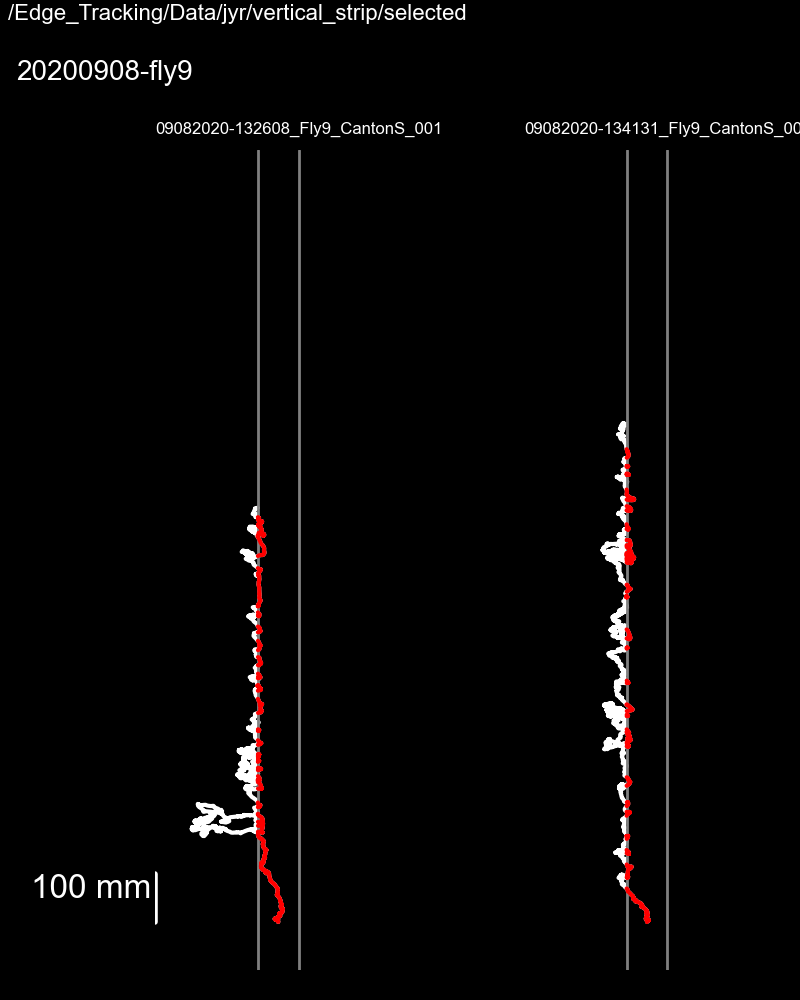

<IPython.core.display.Javascript object>


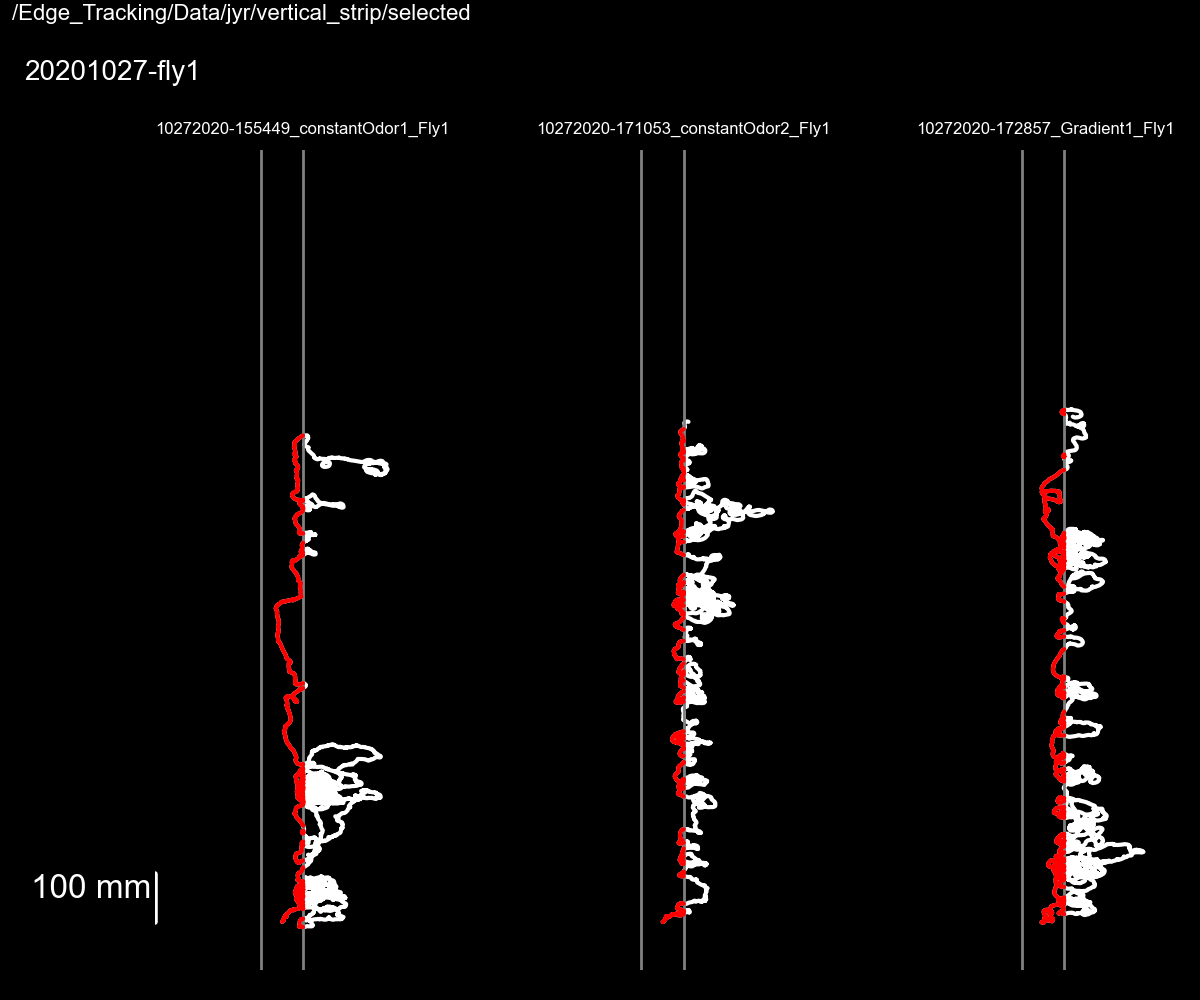

<IPython.core.display.Javascript object>


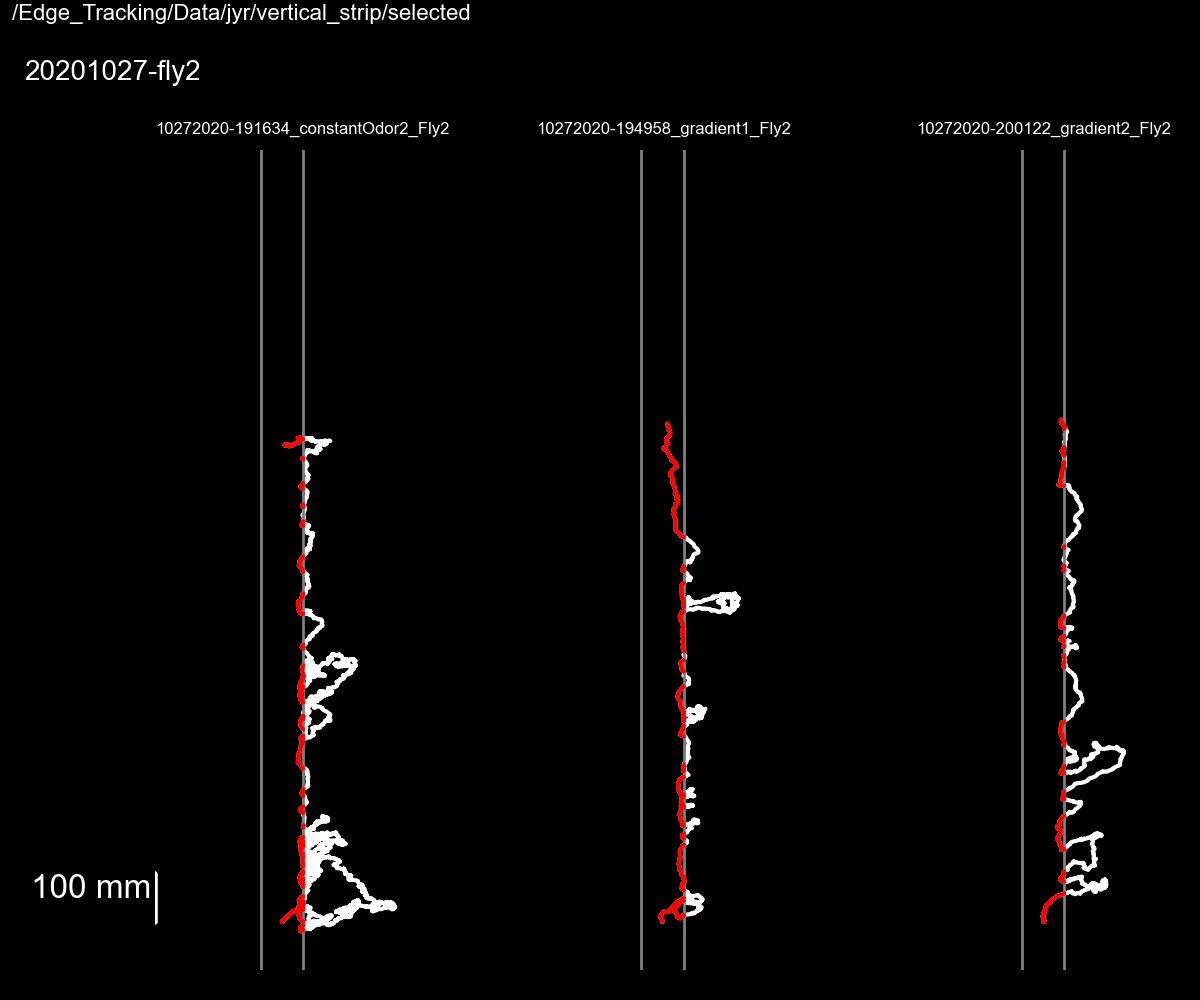

<IPython.core.display.Javascript object>


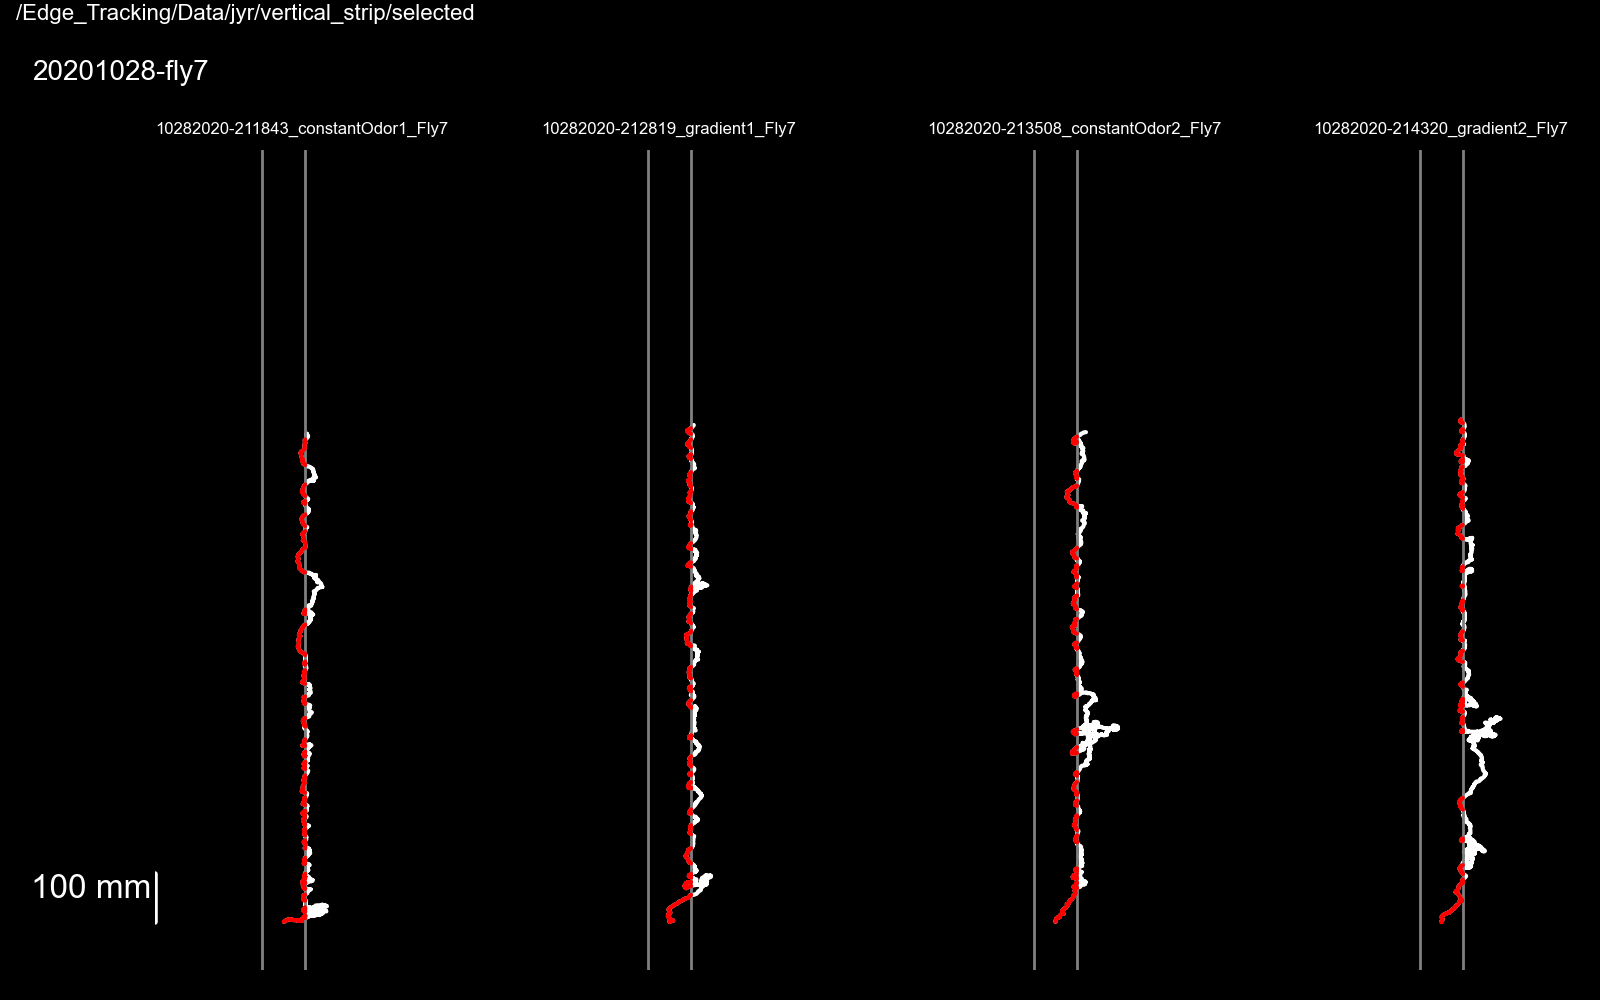

<IPython.core.display.Javascript object>


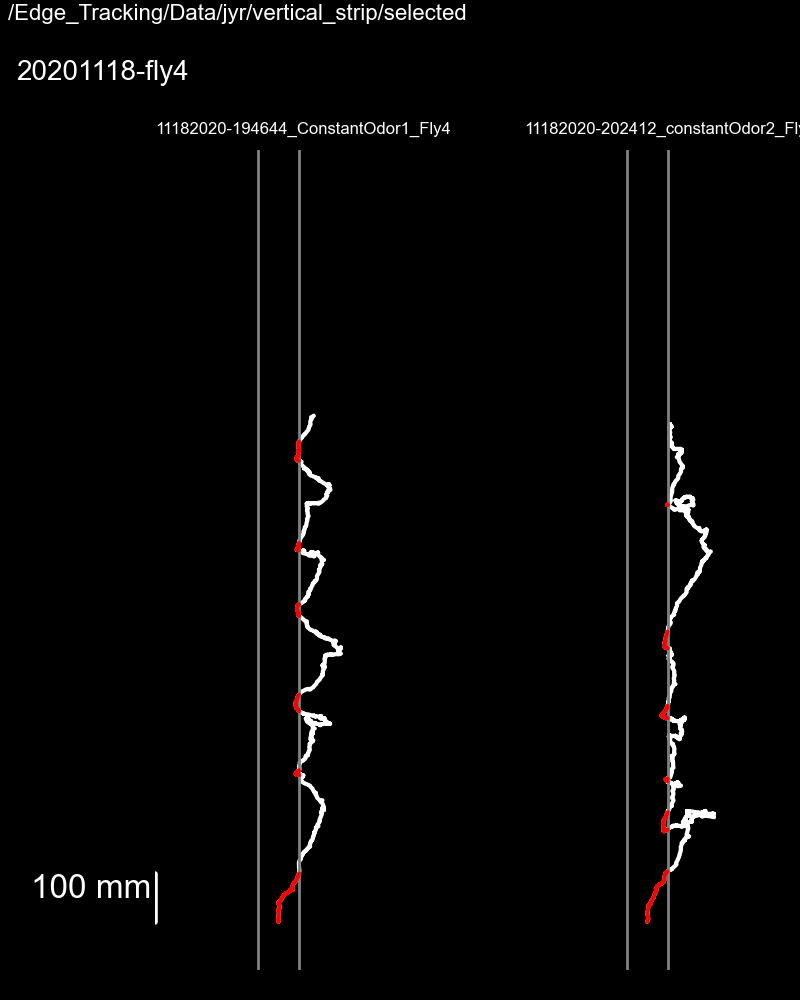

In [313]:
curr_figdir = os.path.join(srcdir, 'ets', 'by_fly')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
    
for fly_id, currdf in df0.groupby('fly_id'):
    fns = currdf['filename'].unique()
    if len(fns) > 1: 
        fig, axn = pl.subplots(1, len(fns), figsize=(len(fns)*2,5), sharex=True)
        for fi, (fn, df_) in enumerate(currdf.groupby('filename')):
            ax=axn.flat[fi]
            # PLOT
            butil.plot_zeroed_trajectory(df_, ax=ax, traj_lw=1.5, odor_lw=1.0,
                                         strip_width=50, #params[fn]['strip_width'],
                                         strip_sep=1000) #params[fn]['strip_sep'])
            # legend
            ax.axis('off')
            if fi==0:
                leg_xpos=-150; leg_ypos=0; leg_scale=100
                butil.vertical_scalebar(ax, leg_xpos=leg_xpos, leg_ypos=leg_ypos)
            #ax.set_box_aspect(3)
            ax.set_xlim([-150, 150])
            ax.set_ylim([-100, 1600])
            ax.set_title(fn, loc='left', fontsize=6)
        fig.text(0.02, 0.92, fly_id)
        pl.tight_layout()
        pl.subplots_adjust(top=0.85, hspace=0.4, wspace=0.5) #left=0.1, right=0.9, wspace=1, hspace=1, bottom=0.1, top=0.8)
        
        util.label_figure(fig, figid)
        
        figname = fly_id
        pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))

In [802]:
df0[['fly_id', 'condition', 'filename']].drop_duplicates().groupby('condition').count()

,fly_id,filename
condition,,
constant,18,18
gradient,18,18


In [803]:
df = df0[df0['condition']=='constant'].copy()
df[['fly_id', 'condition', 'filename']].drop_duplicates().groupby('fly_id').count()

,condition,filename
fly_id,,
20201027-fly1,2,2
20201027-fly2,2,2
20201028-fly4,1,1
20201028-fly6,1,1
20201028-fly7,2,2
20201028-fly8,1,1
20201117-fly2,1,1
20201117-fly3,1,1
20220530-fly0,1,1


In [804]:
df = df.drop(columns=['level_0'])

In [805]:
bdf = pd.concat([df_.groupby('boutnum').apply(butil.get_bout_metrics).unstack().reset_index() \
       for fn, df_ in df.groupby(['filename', 'condition'])]).reset_index()

bdf.shape

(1032, 28)

In [806]:
check_cols=[]
for c in bdf.columns.tolist():
    if not pd.api.types.is_numeric_dtype(bdf[c]):
        check_cols.append(c)

non_numeric = [
    'experiment',
    'filename',
    'fly_name',
    'fpath',
    'strip_type',
    'trial']
fix_cols = [c for c in check_cols if c not in non_numeric]
for c in fix_cols:
    bdf[c] = bdf[c].astype(float)
check_cols

['average_ft_heading',
 'crosswind_dist_firstlast',
 'crosswind_dist_range',
 'crosswind_speed',
 'date',
 'duration',
 'experiment',
 'filename',
 'fly_name',
 'fpath',
 'index',
 'instrip',
 'led_on',
 'n_frames',
 'odor_on',
 'path_length',
 'path_length_x',
 'path_length_y',
 'rel_time',
 'sig_status',
 'speed',
 'strip_type',
 'trial',
 'upwind_dist_firstlast',
 'upwind_dist_range',
 'upwind_speed']

In [807]:
meandf = bdf.groupby(['filename', 'instrip']).mean().reset_index()
meandf.shape

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_83073/3166467201.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meandf = bdf.groupby(['filename', 'instrip']).mean().reset_index()


(36, 23)

In [808]:
meandf['bout_type'] = ['instrip' if i==1 else 'outstrip' for i in meandf['instrip']]

In [809]:
curr_figdir

'/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data/jyr/vertical_strip/selected/ets'

In [810]:
bdf[bdf['filename']==bdf['filename'].unique()[0]]['boutnum'].max()

147

<IPython.core.display.Javascript object>


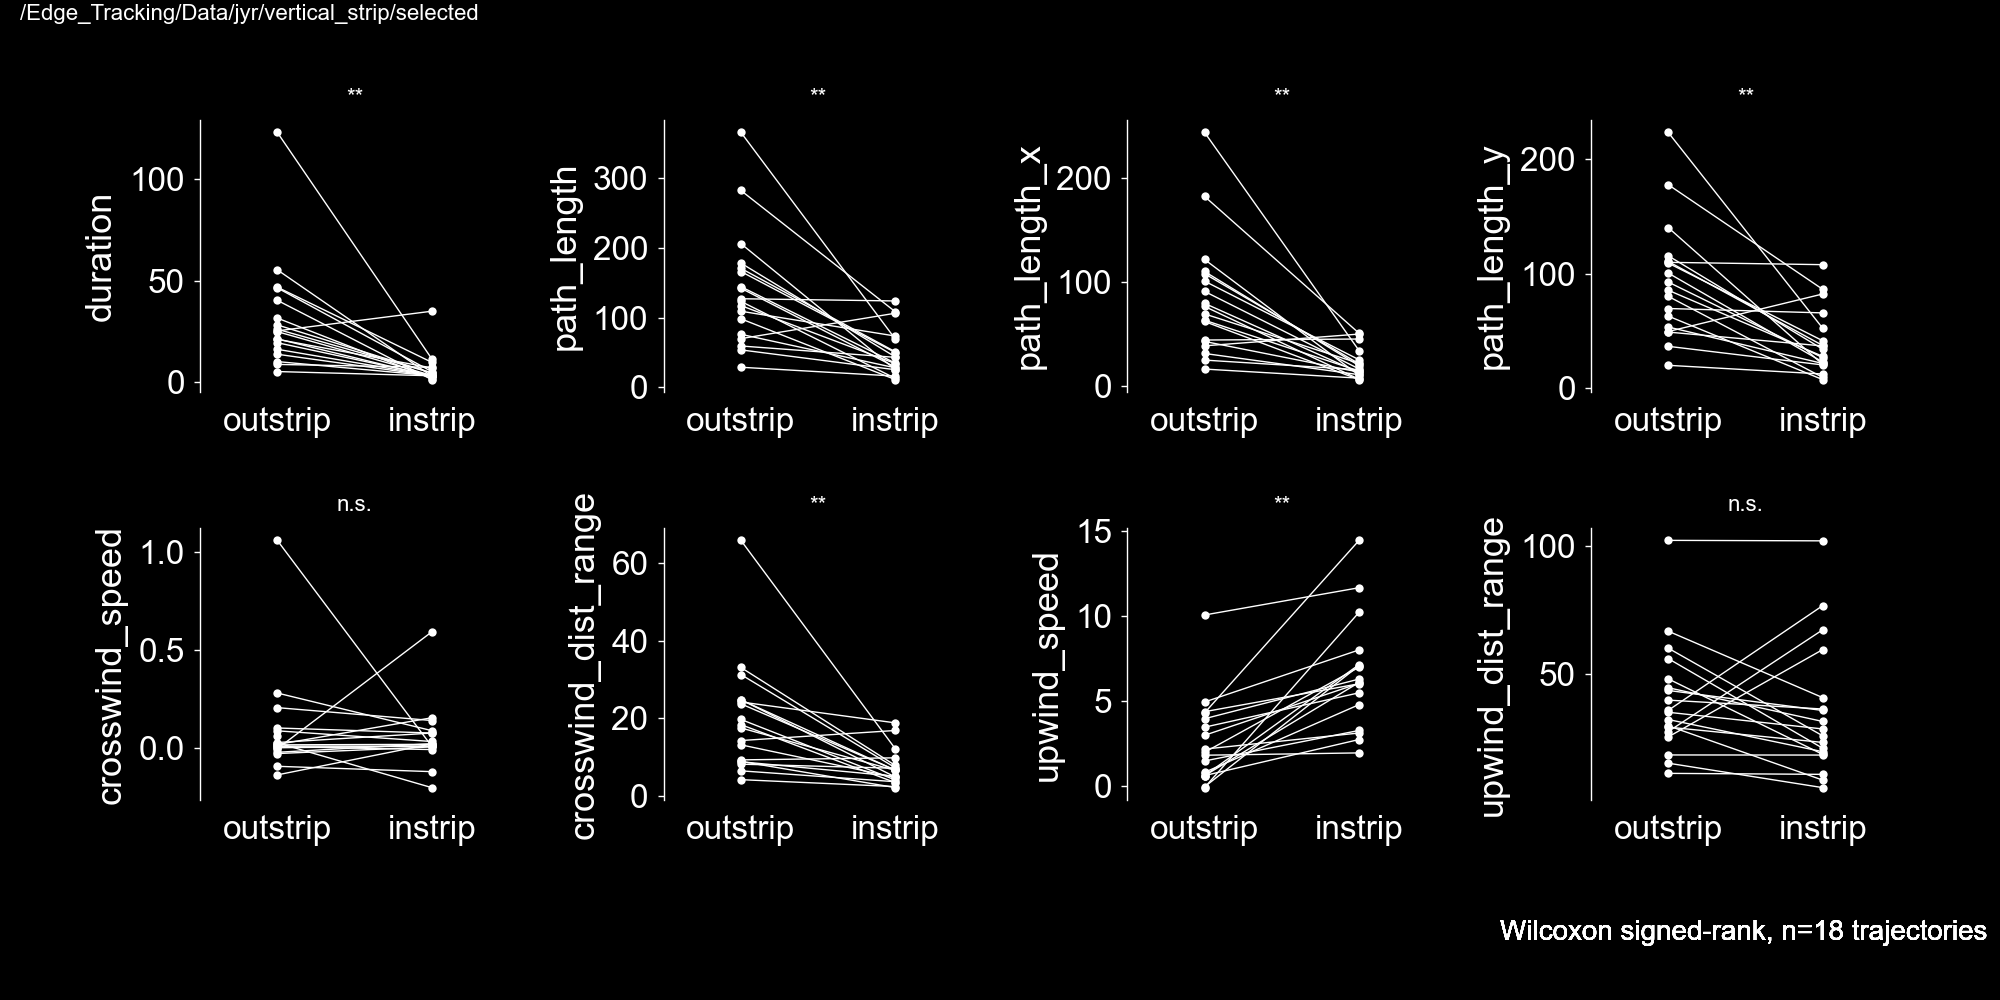

In [811]:
varnames = ['duration', 'path_length',
            'path_length_x', 'path_length_y',
            'crosswind_speed', 'crosswind_dist_range', 
            'upwind_speed', 'upwind_dist_range']

fig, axn = pl.subplots(2, 4, figsize=(10,5)) #len(varnames))

for ax, varn in zip(axn.flat, varnames):
    sns.stripplot(data=meandf, x='bout_type', y=varn, ax=ax, c='w', s=3, jitter=False)
    for f, fd in meandf.groupby('filename'):
        ax.plot([0, 1],
            [fd[fd['instrip']==0][varn], fd[fd['instrip']==1][varn]],
                'w', lw=0.5)
    ax.tick_params(which='both', axis='both', length=2, width=0.5, color='w',
                   direction='out', left=True)
    for pos in ['right', 'top', 'bottom']:
       ax.spines[pos].set_visible(False)
    ax.set_xlabel('')
    ax.set_xlim([-0.5, 1.5])
    # 
    a = meandf[meandf['instrip']==0][varn].values
    b = meandf[meandf['instrip']==1][varn].values
    pdf = pd.DataFrame({'a': a, 'b': b})
    T, pv = spstats.wilcoxon(pdf["a"], pdf["b"], nan_policy='omit')
    if pv>=0.05:
        star = 'n.s.'
    else:
        star = '**' if pv<0.01 else '*'
    ax.set_title(star, fontsize=8)
    dof = len(a)-1
    fig.text(0.75, 0.06, 'Wilcoxon signed-rank, n={} trajectories'.format(len(a)),
            fontsize=10)
pl.subplots_adjust(left=0.1, wspace=0.5, hspace=0.5, right=0.95, bottom=0.2)
util.label_figure(fig, figid)
pl.savefig(os.path.join(curr_figdir, 'summary-metrics.png'))


In [819]:
importlib.reload(traj)
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [820]:
boutdir_palette = {'outbound': 'cyan', 'inbound': 'violet'} #'cyan'}

In [836]:
plot=False
strip_width=50
strip_sep=1000
t_list = []
for fn, df_ in df.groupby('filename'):
    print(fn)
    tmpdf = df_.copy().reset_index(drop=True)
    odor_bounds = butil.find_strip_borders(tmpdf, 
                                        entry_ix=tmpdf[tmpdf['instrip']].iloc[0].name,
                                        strip_width=strip_width, strip_sep=strip_sep)
    
    # find all ET bouts (in case there is more than 1)
    et_bouts, et_boutstats, et_passkey = traj.find_et_bouts(tmpdf, odor_bounds, 
                                    strip_width=strip_width, strip_sep=strip_sep)
    et_boutkey = traj.get_best_et_boutkey(et_boutstats)
    # select best ET
    df_best, odor_ix, et_bouts = traj.select_best_et_bout(
                                            et_boutkey, et_bouts, tmpdf, strip_sep=strip_sep)
    # flip trajectory so all riding along strip's right side
    df_flipped, obounds_fp = traj.check_and_flip_traj(tmpdf,
                                        et_boutkey, et_boutstats, et_bouts, 
                                                      strip_width=strip_width)
    # get final DF
    df_final = df_flipped.loc[odor_ix:].copy()
    obounds = list(obounds_fp.values())
    # calculate tortuosity metrics
    tortdf = traj.calculate_tortuosity_metrics(df_final, xdist_cutoff=1.9)
    tortdf['filename'] = fn
    if plot:
        fig = traj.plot_tortuosity_metrics(tortdf, cdf=False, boutdir_palette=boutdir_palette)
        fig.text(0.05, 0.9, fn, fontsize=10)
        util.label_figure(fig, "{}".format(figid))
        pl.subplots_adjust(right=0.8)
    
    t_list.append(tortdf)

05302022-190526_constantOdor_Fly0
0: starts instrip False
Aggregate: 1469.8673334922337
curr et key: 0
Is ET: 0 True
0 147
-1 86883
Not flipping borders
06022022-133201_CantonS_constantOdor_Fly1
0: starts instrip False
Aggregate: 980.7683832159598
curr et key: 0
Is ET: 0 True
0 20
926 5864
Not flipping borders
19
16
19
06022022-143134_CantonS_constantOdor_Fly2_
0: starts instrip False
Aggregate: 1117.2729521581023
curr et key: 0
Is ET: 0 True
0 32
-1 16617
Not flipping borders
06092022-155055_spontaneousTracking_Fly1
0: starts instrip False
Aggregate: 1653.3053752322207
curr et key: 0
Is ET: 0 True
0 158
1793 44150
Not flipping borders
06092022-171500_SpontaneousTracking_Fly3


/Users/julianarhee/Repositories/plume-tracking/utils.py:111: RuntimeWarning: invalid value encountered in double_scalars
  tortuosity = pathlength/maxdist


0: starts instrip False
Aggregate: 2091.2213703602183
curr et key: 0
Is ET: 0 True
0 115
-1 87081
Not flipping borders
06132022-115953_SpontaneousTracking_Fly5
0: starts instrip False
Aggregate: 926.4657393373237
curr et key: 0
Is ET: 0 True
0 25
-1 27709
Not flipping borders
06132022-131030_SpontaneousTracking_Fly7
0: starts instrip False
Aggregate: 743.2138236009002
curr et key: 0
Is ET: 0 True
0 41
1815 24115
Not flipping borders
10272020-155449_constantOdor1_Fly1
0: starts instrip True
Aggregate: 2403.126786261914
curr et key: 0
Is ET: 0 True
0 66
-1 60907
Not flipping borders
10272020-171053_constantOdor2_Fly1
0: starts instrip True
Aggregate: 2014.3660026783264
curr et key: 0
Is ET: 0 True
0 78
-1 53163
Not flipping borders
10272020-185128_constantOdor1_Fly2
0: starts instrip True
Aggregate: 957.7897920056763
curr et key: 0
Is ET: 0 True
0 48
-1 81637
Not flipping borders
10272020-191634_constantOdor2_Fly2
0: starts instrip True
Aggregate: 2059.307813977831
curr et key: 0
Is ET: 

/Users/julianarhee/Repositories/plume-tracking/utils.py:111: RuntimeWarning: invalid value encountered in double_scalars
  tortuosity = pathlength/maxdist


507
2067
10282020-211843_constantOdor1_Fly7
0: starts instrip True
Aggregate: 1081.6509187515844
curr et key: 0
Is ET: 0 True
0 60
-1 30568
Not flipping borders
10282020-213508_constantOdor2_Fly7
0: starts instrip True
Aggregate: 1063.3863105603596
curr et key: 0
Is ET: 0 True
0 44
-1 25771
Not flipping borders
10282020-220510_constantOdor1_Fly8
0: starts instrip True
Aggregate: 1842.5354802419279
curr et key: 0
Is ET: 0 True
0 36
-1 55916
Not flipping borders
4955
11172020-180949_ConstantOdor1_Fly2
0: starts instrip True
Aggregate: 844.0341975592229
curr et key: 0
Is ET: 0 True
0 26
-1 6662
11172020-203121_constantOdor1_Fly3
0: starts instrip True
Aggregate: 994.887675805005
curr et key: 0
Is ET: 0 True
0 30
-1 25788


## tortuosity

In [837]:
tdf = pd.concat(t_list, axis=0).reset_index(drop=True)

In [838]:
meandf = tdf.groupby(['filename', 'boutdir']).mean().reset_index()


<IPython.core.display.Javascript object>


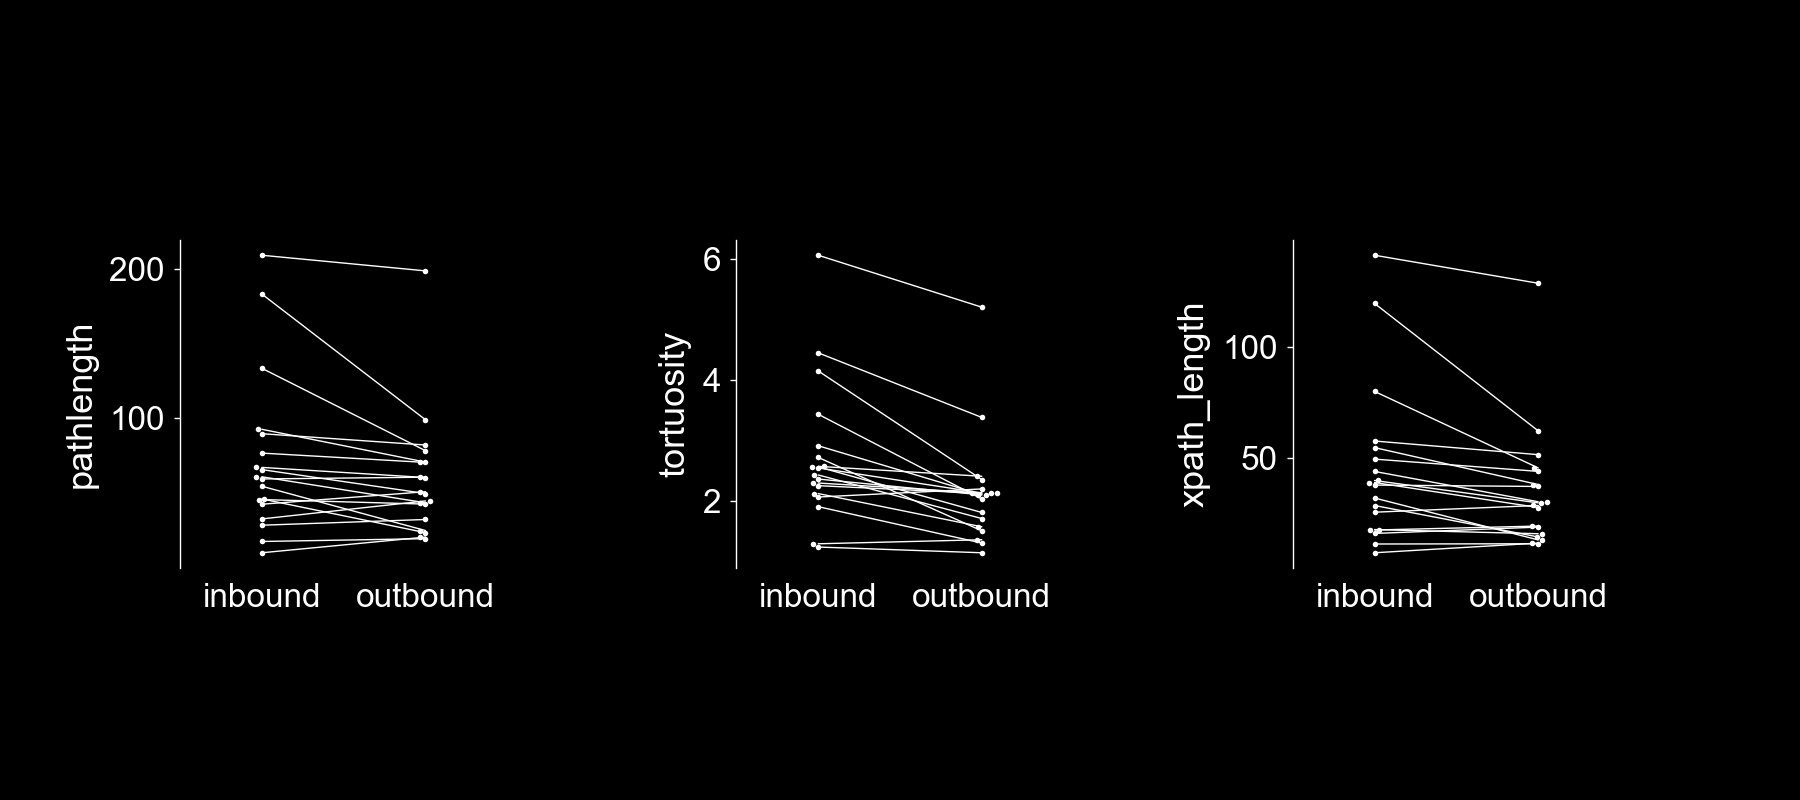

In [840]:
fig, axn = pl.subplots(1, 3, figsize=(9,4))

varnames = ['pathlength', 'tortuosity', 'xpath_length']
for ax, varname in zip(axn.flat, varnames):
    sns.swarmplot(data=meandf, y=varname, x='boutdir', ax=ax, c='w', s=2)
    for f, fd in meandf.groupby('filename'):
        ax.plot([0, 1],
                [fd[fd['boutdir']=='inbound'][varname], fd[fd['boutdir']=='outbound'][varname]],
                'w', lw=0.5)
    ax.set_box_aspect(1)
    ax.tick_params(which='both', axis='both', length=2, width=0.5, color='w',
                   direction='out', left=True)
    for pos in ['right', 'top', 'bottom']:
       ax.spines[pos].set_visible(False)
    ax.set_xlabel('')
    ax.set_xlim([-0.5, 1.5])
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.7)
 
#pl.savefig(os.path.join(figdir, 'all-flies-summary-tortuosity.png'))